In [4]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FuncFormatter
import copy
from sklearn.linear_model import LinearRegression
import netCDF4
import rioxarray
import xarray as xr
import statsmodels.api as sm
import datetime
from shapely.geometry import mapping

## 1.读取数据

In [2]:
#2000-2019年中国湖泊时序重构数据集
China_Lakes_time_series=pd.read_csv(r'1_data\lake area time series_2000-2019_China.csv').dropna()
China_Lakes_time_series

,GLAKES_ID,Year,Reservoir_flag,Area_raw,Area_dr
0,44,2000,0,151.452703,1211.170476
1,44,2001,0,1030.693554,1210.341072
2,44,2002,0,472.115406,1210.310305
3,44,2003,0,1212.516327,1214.170653
4,44,2004,0,1207.558202,1212.641128
...,...,...,...,...,...
143575,192203,2015,0,0.978261,0.979147
143576,192203,2016,0,0.956111,0.956259
143577,192203,2017,0,0.931747,0.931747
143578,192203,2018,0,0.915504,0.915947


In [3]:
#GLAKES数据集
GLAKES_China=gpd.read_file(r'1_data\GLAKES_of_China.shp')
GLAKES_China

KeyboardInterrupt: 

In [5]:
#从GLAKES中筛选出研究数据
lake=GLAKES_China.query('Lake_id in {}'.format(China_Lakes_time_series['GLAKES_ID'].unique().tolist()))
lake=lake[lake['Rser_flag']==0]
lake.to_file('interest_lakes.shp', driver='ESRI Shapefile')
lake

,Lake_id,Area_bound,Area_PW,Continent,Lat,Lon,GFed_flag,PFed_flag,Endo_flag,Rser_flag,geometry
0,44,4498.820861,4289.251642,Asia,44.999539,132.411587,0,0,0,0,"POLYGON ((132.41225 45.39100, 132.41150 45.391..."
1,46,4457.092587,4231.328844,Asia,36.886724,100.200635,0,0,1,0,"POLYGON ((100.13700 37.19325, 100.13700 37.193..."
2,66,3031.205287,2164.176296,Asia,29.121175,116.280422,0,0,0,0,"POLYGON ((116.71650 28.84200, 116.71600 28.842..."
3,83,2457.415850,2289.655330,Asia,31.200394,120.203463,0,0,0,0,"POLYGON ((120.25375 31.51875, 120.25325 31.518..."
4,85,2402.534003,2226.395455,Asia,31.800787,88.992953,0,1,1,0,"POLYGON ((89.10375 32.07150, 89.10075 32.07150..."
...,...,...,...,...,...,...,...,...,...,...,...
7184,192012,1.001222,0.698583,Asia,31.069351,119.934336,0,0,0,0,"POLYGON ((119.92825 31.07075, 119.92825 31.071..."
7185,192137,1.000452,0.340814,Asia,43.312370,87.196997,0,1,1,0,"POLYGON ((87.18950 43.30275, 87.18950 43.30125..."
7186,192145,1.000432,0.436983,Asia,30.496623,114.685978,0,0,0,0,"POLYGON ((114.69300 30.49500, 114.69300 30.494..."
7187,192169,1.000210,0.112500,Asia,38.865917,106.375068,0,0,0,0,"POLYGON ((106.37875 38.86675, 106.37950 38.866..."


In [21]:
lake=gpd.read_file('interest_lakes.shp')
lake

,Lake_id,Area_bound,Area_PW,Continent,Lat,Lon,GFed_flag,PFed_flag,Endo_flag,Rser_flag,geometry
0,44,4498.820861,4289.251642,Asia,44.999539,132.411587,0,0,0,0,"POLYGON ((132.41225 45.39100, 132.41150 45.391..."
1,46,4457.092587,4231.328844,Asia,36.886724,100.200635,0,0,1,0,"POLYGON ((100.13700 37.19325, 100.13700 37.193..."
2,66,3031.205287,2164.176296,Asia,29.121175,116.280422,0,0,0,0,"POLYGON ((116.71650 28.84200, 116.71600 28.842..."
3,83,2457.415850,2289.655330,Asia,31.200394,120.203463,0,0,0,0,"POLYGON ((120.25375 31.51875, 120.25325 31.518..."
4,85,2402.534003,2226.395455,Asia,31.800787,88.992953,0,1,1,0,"POLYGON ((89.10375 32.07150, 89.10075 32.07150..."
...,...,...,...,...,...,...,...,...,...,...,...
6061,192012,1.001222,0.698583,Asia,31.069351,119.934336,0,0,0,0,"POLYGON ((119.92825 31.07075, 119.92825 31.071..."
6062,192137,1.000452,0.340814,Asia,43.312370,87.196997,0,1,1,0,"POLYGON ((87.18950 43.30275, 87.18950 43.30125..."
6063,192145,1.000432,0.436983,Asia,30.496623,114.685978,0,0,0,0,"POLYGON ((114.69300 30.49500, 114.69300 30.494..."
6064,192169,1.000210,0.112500,Asia,38.865917,106.375068,0,0,0,0,"POLYGON ((106.37875 38.86675, 106.37950 38.866..."


In [5]:
six_region=gpd.read_file(r'1_data\CN_div6_wgs84.shp')
bou_2_4l=gpd.read_file(r'1_data\bou2_4l.shp')
nine_Line=gpd.read_file(r'1_data\九段线.shp')
southern_sea_island=gpd.read_file(r'1_data\南海诸岛及其它岛屿.shp')
six_region

,AREA,name,geometry
0,1631730.0,XJ,"POLYGON ((86.85125 49.10808, 86.85143 49.10839..."
1,789579.0,NE,"MULTIPOLYGON (((121.59513 38.79301, 121.59442 ..."
2,2064510.0,EP,"MULTIPOLYGON (((109.67783 18.18660, 109.67836 ..."
3,1899130.0,TP,"POLYGON ((97.02007 39.20921, 97.02058 39.20905..."
4,1985600.0,MP,"POLYGON ((121.49761 53.32596, 121.50095 53.321..."
5,1127780.0,YG,"POLYGON ((102.91254 34.31357, 102.91420 34.312..."


## 2.绘制地图
https://blog.csdn.net/qq_35240689/article/details/130132703
https://gis.stackexchange.com/questions/388512/adding-custom-names-to-a-geopandas-legend

In [6]:
proj = ccrs.LambertConformal(central_longitude=105, 
                              central_latitude=40,
                              standard_parallels=(25.0, 47.0))
lw=[0.25,0.5,0.8,1,2] #line width (px)
fs=[8,12,14] #font size (px)
plt.rc('font',family='Arial', size=fs[0])
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
colors = {0:'#EEDD82', 1:'#D8BFD8', 2:'#FFB5C5', 3:'#EE6363',4:'#F4A460',5:'#90EE90'}
regions=['EP','MP','XJ','NE','YG','TP']

In [11]:
def add_northern_sea(ax):
    ax.add_geometries(bou_2_4l['geometry'],facecolor='white',edgecolor='black',linewidth=lw[1],crs=ccrs.PlateCarree())
    ax.add_geometries(nine_Line['geometry'],color='black',linewidth=lw[1],crs=ccrs.PlateCarree())
    ax.add_geometries(southern_sea_island['geometry'],facecolor='white',edgecolor='black',linewidth=lw[1],crs=ccrs.PlateCarree())

def draw_label(ax,x,y,text):
    ax.text(x,y,text,transform=ax.transAxes)

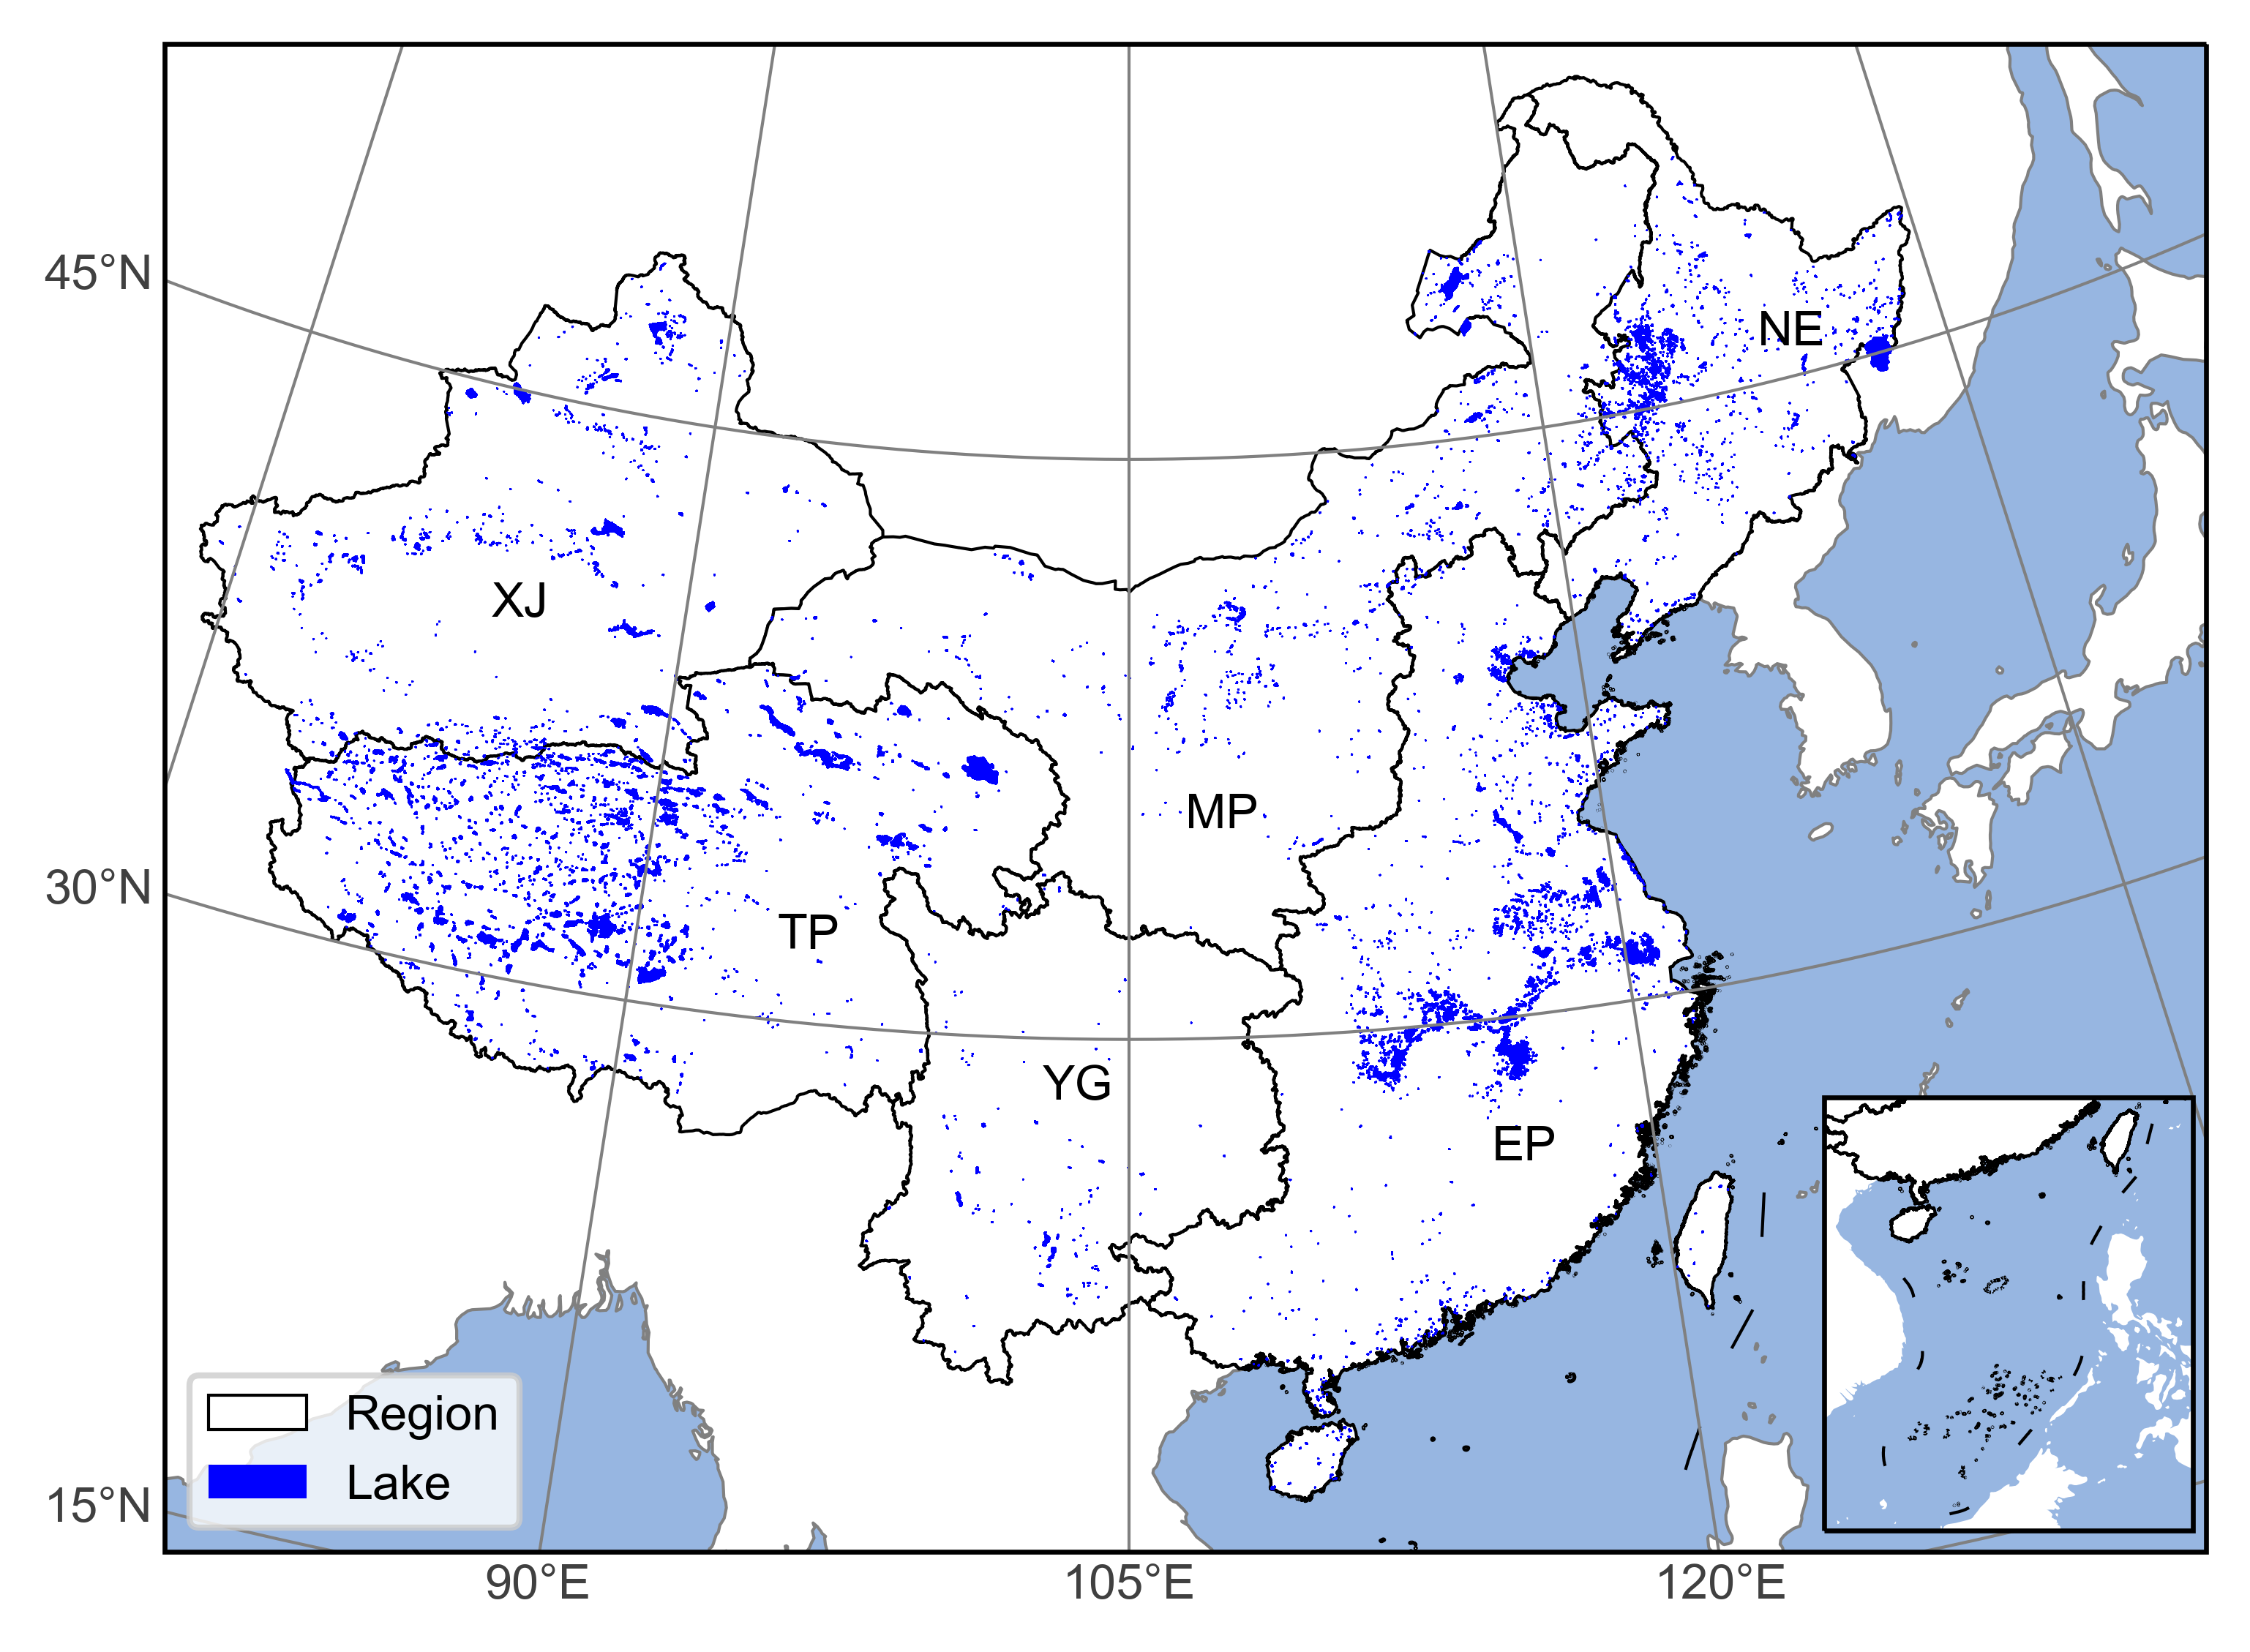

In [532]:
fig = plt.figure(figsize=(6,4.8), dpi=600) #inch
ax=plt.axes(projection=proj)
ax.spines['geo'].set_linewidth(lw[2])
ax.set_extent([80, 133, 17, 53], crs=ccrs.PlateCarree())

#添加地图基本要素
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, edgecolor='gray', facecolor='white',linewidth=lw[1], zorder=1)
add_northern_sea(ax)

#添加六大湖区
ax.add_geometries(six_region["geometry"],linewidth=lw[1],crs=ccrs.PlateCarree(),facecolor='w',edgecolor='black')
draw_label(ax,0.3,0.4,'TP')
draw_label(ax,0.43,0.3,'YG')
draw_label(ax,0.65,0.26,'EP')
draw_label(ax,0.5,0.48,'MP')
draw_label(ax,0.78,0.8,'NE')
draw_label(ax,0.16,0.62,'XJ')

#添加研究的湖泊
ax.add_geometries(lake["geometry"],crs=ccrs.PlateCarree(),facecolor='blue',edgecolor='blue',linewidth=lw[0])

#添加图例
pmarks = []
pmarks.append(Patch(facecolor='w', edgecolor='black',label='Region',linewidth=lw[1]))
# pmarks.append(Patch(facecolor='red', label='Reservoir'))
pmarks.append(Patch(facecolor='blue', label='Lake'))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[*handles,*pmarks], loc='lower left')

#设置格网
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), 
                   color='gray',  linewidth=lw[1], 
                   y_inline=False, x_inline=False,
                   rotate_labels=0,xpadding=2,ypadding=2,
                   xlocs=range(-180,180,15), ylocs=range(-90,90,15),
                   xlabel_style={"size":fs[0],'color': "0.25"},
                   ylabel_style={"size":fs[0],'color': "0.25"}
                  )         
gls.top_labels=False
gls.right_labels=False

ax2 = fig.add_axes([0.755, 0.125, 0.14, 0.25], projection = ccrs.PlateCarree())
ax2.set_extent([105, 125, 2.5, 26],crs=ccrs.PlateCarree())
ax2.spines['geo'].set_linewidth(lw[2])

ax2.add_feature(cfeature.OCEAN, zorder=0)
ax2.add_geometries(six_region["geometry"],crs=ccrs.PlateCarree(),facecolor='white',edgecolor='black',linewidth=lw[1])
add_northern_sea(ax2)

## 3.Lake distribution and lake changes between 2000 and 2019

In [117]:
columns=['Lake_id','Region','2000','2019']
lake_list=pd.DataFrame(columns=columns)
index=0
for l_id in tqdm(lake.index):
    for r_id in six_region.index:
        region=six_region.loc[r_id]['geometry']
        region_name=six_region.loc[r_id]['name']
        if region.contains(lake.loc[l_id]['geometry'].centroid):
            lake_id=lake.loc[l_id]['Lake_id']
            lake_time_series=copy.copy(China_Lakes_time_series[China_Lakes_time_series['GLAKES_ID']==lake_id])
            try:
                a1=lake_time_series[lake_time_series['Year']==2019].iloc[0,4]
                a2=lake_time_series[lake_time_series['Year']==2019].iloc[0,4]
#                 print(a2)
                l=[lake_id,region_name,a1,a2]
                lake_list.loc[index]=l
                index=index+1 
                break                
            except:
                break        
# lake_list.to_csv('lake_list_2000_2019.csv')        
lake_list

  0%|          | 0/6066 [00:00<?, ?it/s]

,Lake_id,Region,2000,2019
0,46,TP,4450.111029,4450.111029
1,66,EP,2407.341280,2407.341280
2,83,EP,2350.433833,2350.433833
3,85,TP,2385.171297,2385.171297
4,99,MP,2047.085612,2047.085612
...,...,...,...,...
5844,192012,EP,0.871945,0.871945
5845,192137,XJ,0.984482,0.984482
5846,192145,EP,0.619330,0.619330
5847,192169,MP,0.027290,0.027290


In [28]:
lake_list=pd.read_csv('lake_list_2000_2019.csv')
lake_list

,Unnamed: 0,Lake_id,Region,2000,2019
0,0,46,TP,4258.669508,4450.111029
1,1,66,EP,2717.755934,2407.341280
2,2,83,EP,2362.317242,2350.433833
3,3,85,TP,2038.114052,2385.171297
4,4,99,MP,2079.797208,2047.085612
...,...,...,...,...,...
5078,5078,192012,EP,0.636290,0.871945
5079,5079,192137,XJ,0.166944,0.984482
5080,5080,192145,EP,0.389028,0.619330
5081,5081,192169,MP,0.081870,0.027290


In [29]:
population=pd.read_csv(r'1_data\population.csv')
population

,Region,Population,Percentage
0,NE,"98,514,948",6.834209
1,XJ,"25,852,345",1.793437
2,MP,"105,696,424",7.332405
3,EP,"925,214,519",64.184267
4,TP,"34,591,888",2.399719
5,YG,"251,627,254",17.455963
6,total,"1,441,497,378",100.000000


C:\Users\lenovo\anaconda3\envs\ese5023\lib\site-packages\numpy\lib\stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\lenovo\anaconda3\envs\ese5023\lib\site-packages\matplotlib\transforms.py:789: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  points = np.array(args, dtype=float).reshape(2, 2)


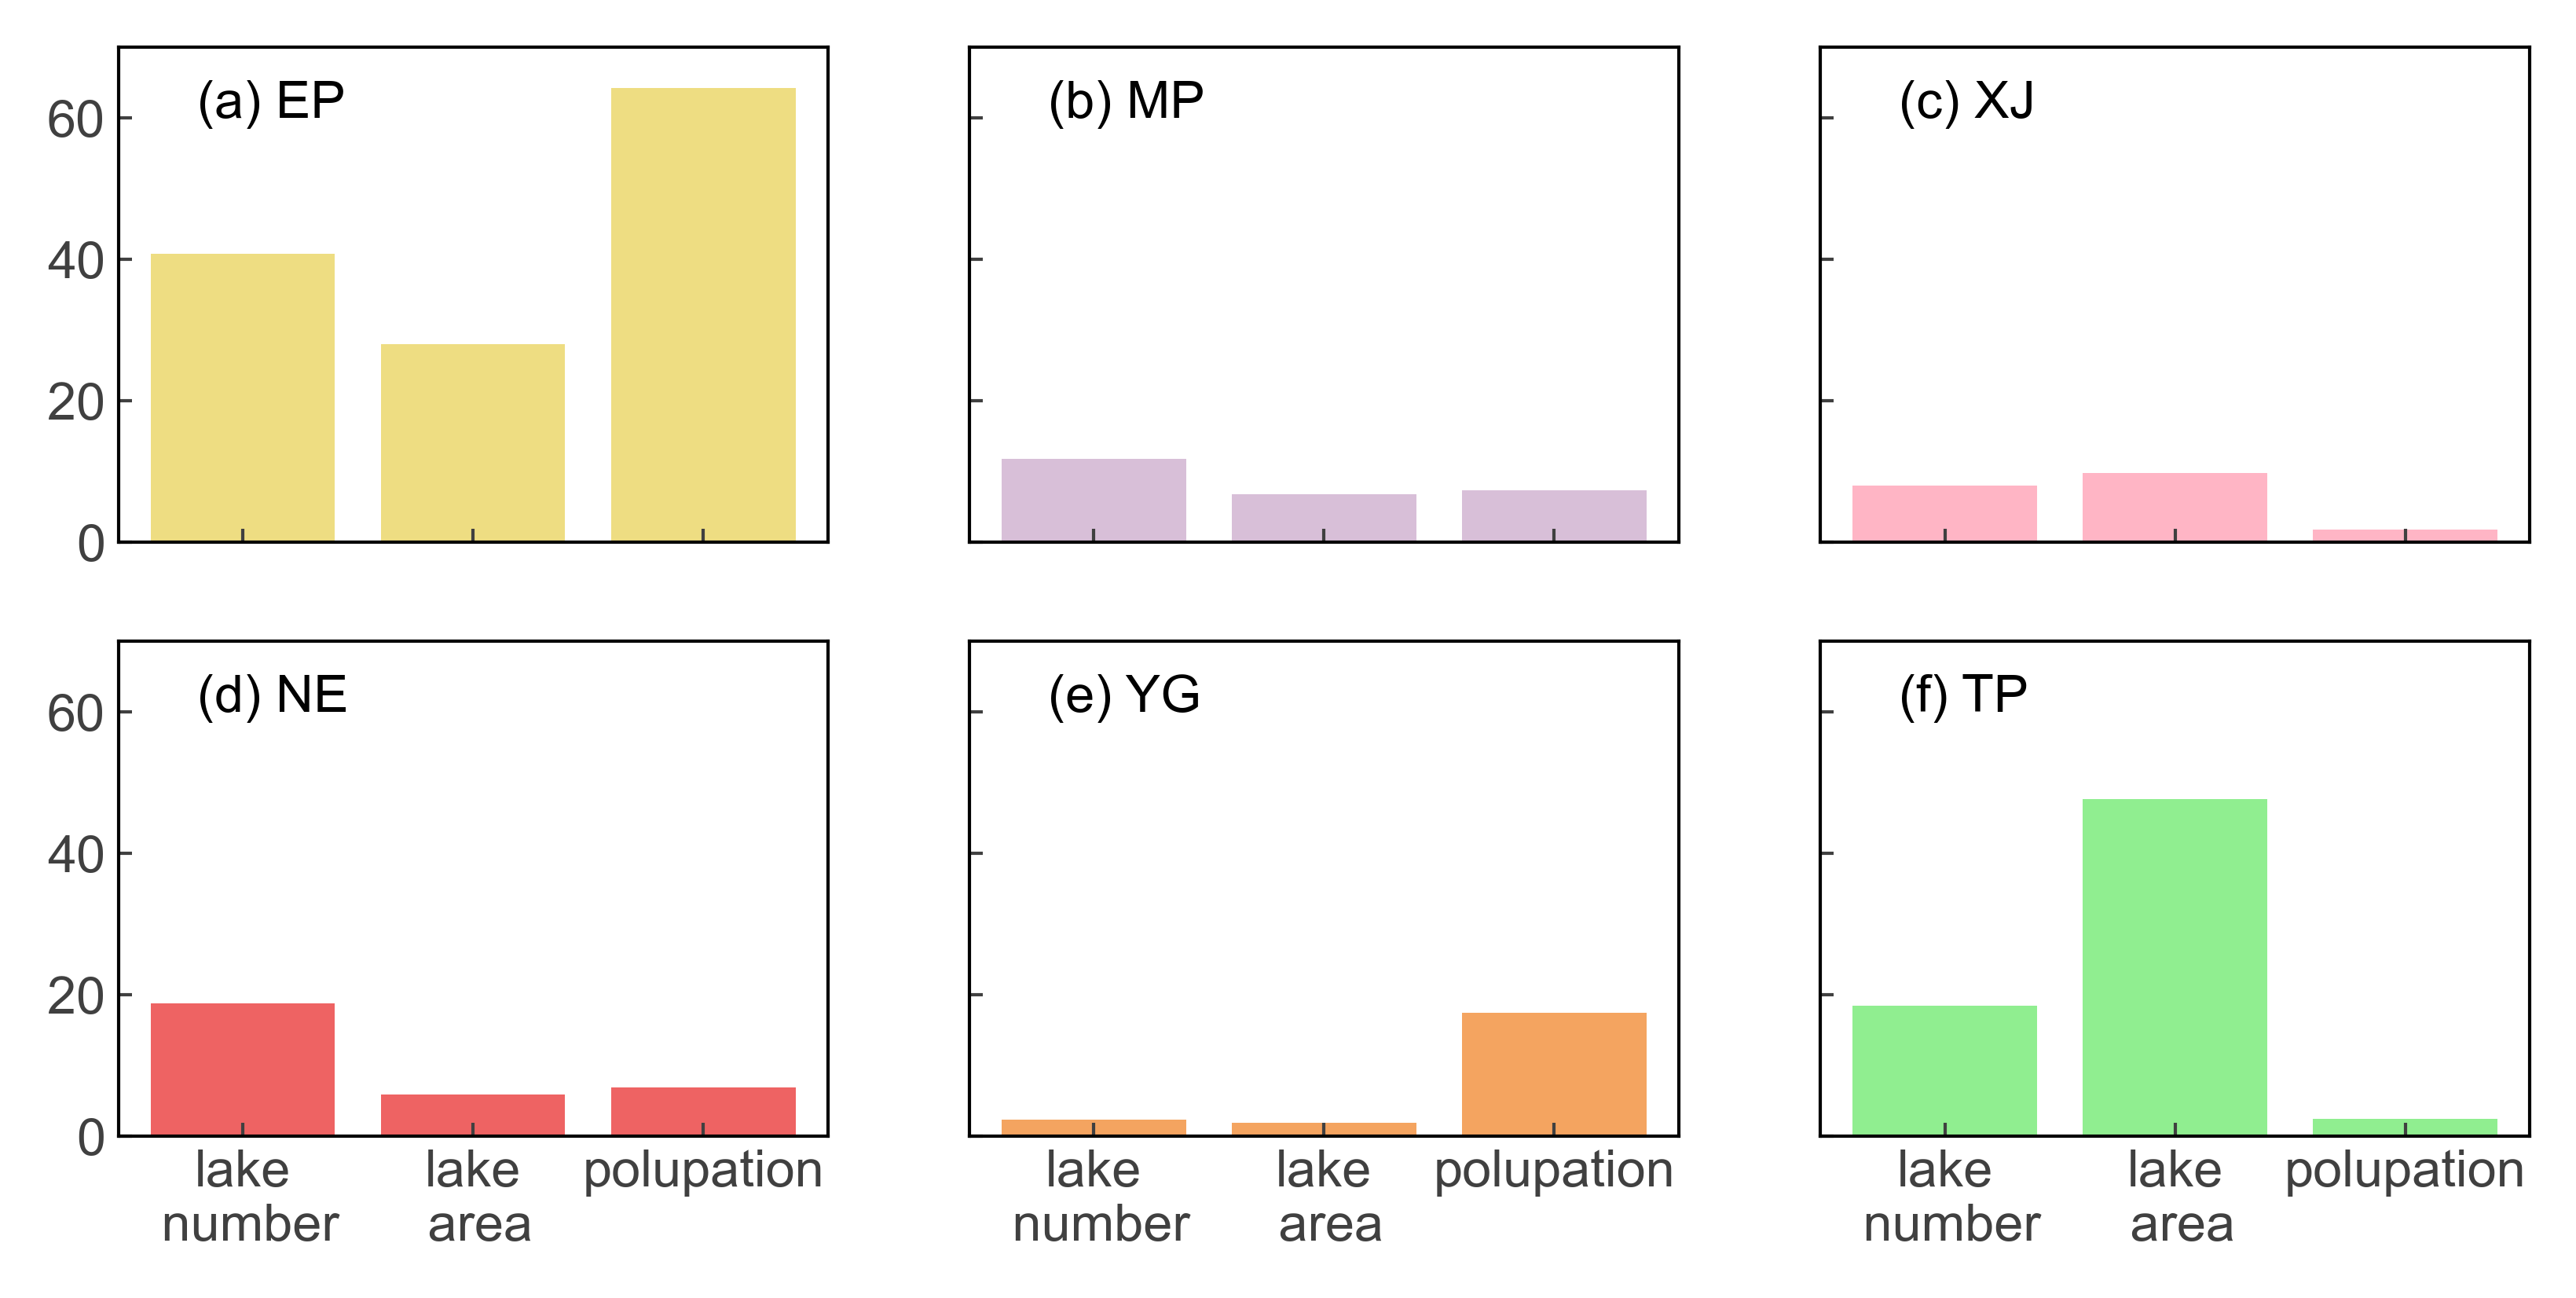

In [30]:
total_ln=len(lake_list[lake_list['2000']!=0])
total_la=lake_list['2000'].sum()
fig, axes = plt.subplots(2,3, figsize=(6.6,3), sharex=True, sharey=True, dpi=600)
for i, ax in enumerate(axes.ravel()):
    region_lake_list=lake_list[lake_list['Region']==regions[i]]
    lake_num_p=len(region_lake_list[region_lake_list['2000']!=0])/total_ln*100
    lake_area_p=region_lake_list['2000'].sum()/total_la*100
    population_p=population[population['Region']==regions[i]]['Percentage']

    ax.text(-0.2,60,'({}) {}'.format(chr(97+i),regions[i]))
    ax.bar(['lake\n number','lake\n area','polupation'],[lake_num_p,lake_area_p,population_p],color=colors[i])
    ax.set_ylim([0,70])
    ax.spines['bottom'].set_linewidth(lw[1])
    ax.spines['top'].set_linewidth(lw[1])#.set_visible(False)
    ax.spines['left'].set_linewidth(lw[1])
    ax.spines['right'].set_linewidth(lw[1])#.set_visible(False)
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)

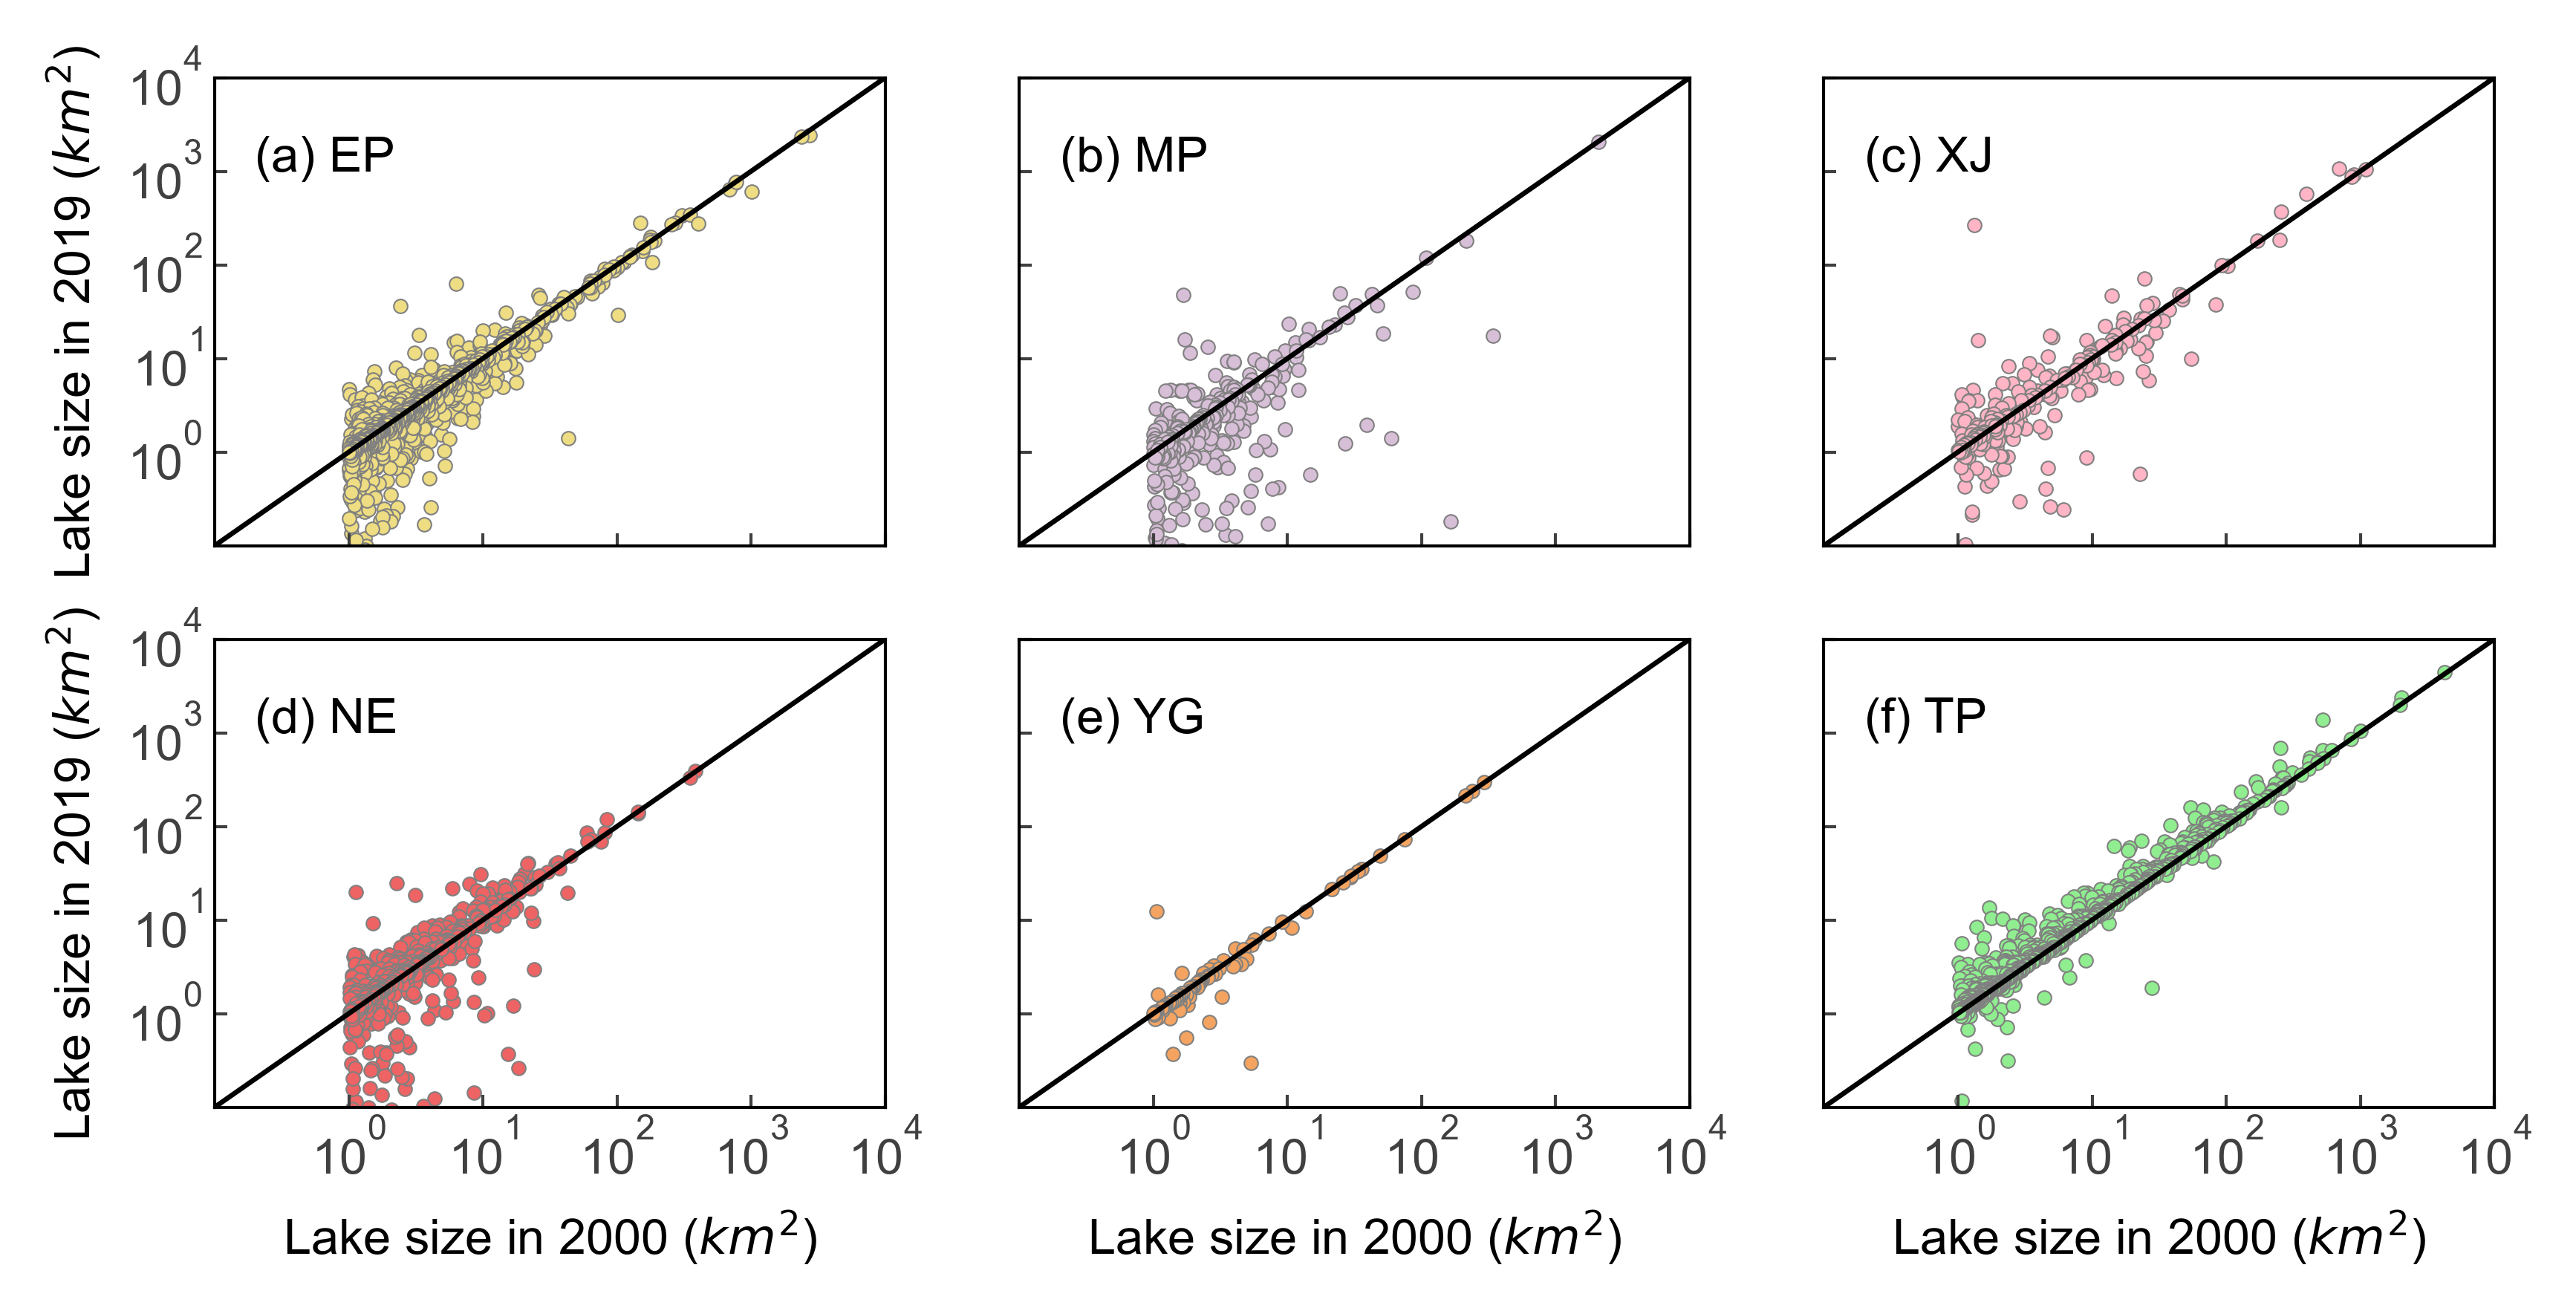

In [34]:
def draw_scatter(ax,color,marker,df,region,minSize,maxSize):
    subset=df[(df['Region']==region)&(df['2000']>=minSize)&(df['2000']<maxSize)]
    x=subset['2000'].tolist()
    y=subset['2019'].tolist()
    ax.scatter(x,y,s=5,c=color,linewidths=lw[0],marker=marker,edgecolors='gray',zorder=0)

ticks=[1,10,100,1000,10000]

fig, axes = plt.subplots(2,3, figsize=(6.6,3), sharex=True, sharey=True, dpi=600)
for i, ax in enumerate(axes.ravel()):
    draw_scatter(ax,colors[i],'o',lake_list,regions[i],1,10000)    
#     draw_scatter(ax,colors[i],'o',lake_list,regions[i],10,100)    
#     draw_scatter(ax,colors[i],'d',lake_list,regions[i],100,10000)  
    
    ax.spines['bottom'].set_linewidth(lw[1])
    ax.spines['top'].set_linewidth(lw[1])#.set_visible(False)
    ax.spines['left'].set_linewidth(lw[1])
    ax.spines['right'].set_linewidth(lw[1])#.set_visible(False)
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)
      
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.1,10000])
    ax.set_ylim([0.1,10000])
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.plot((0, 1), (0, 1), transform=ax.transAxes,c='k',linewidth=lw[2])
    ax.text(0.2,1000,'({}) {}'.format(chr(97+i),regions[i]))
    if i%3==0:
        ax.set_ylabel('Lake size in 2019 ($km^2$)')
    if i>=3:
        ax.set_xlabel('Lake size in 2000 ($km^2$)')
        
    

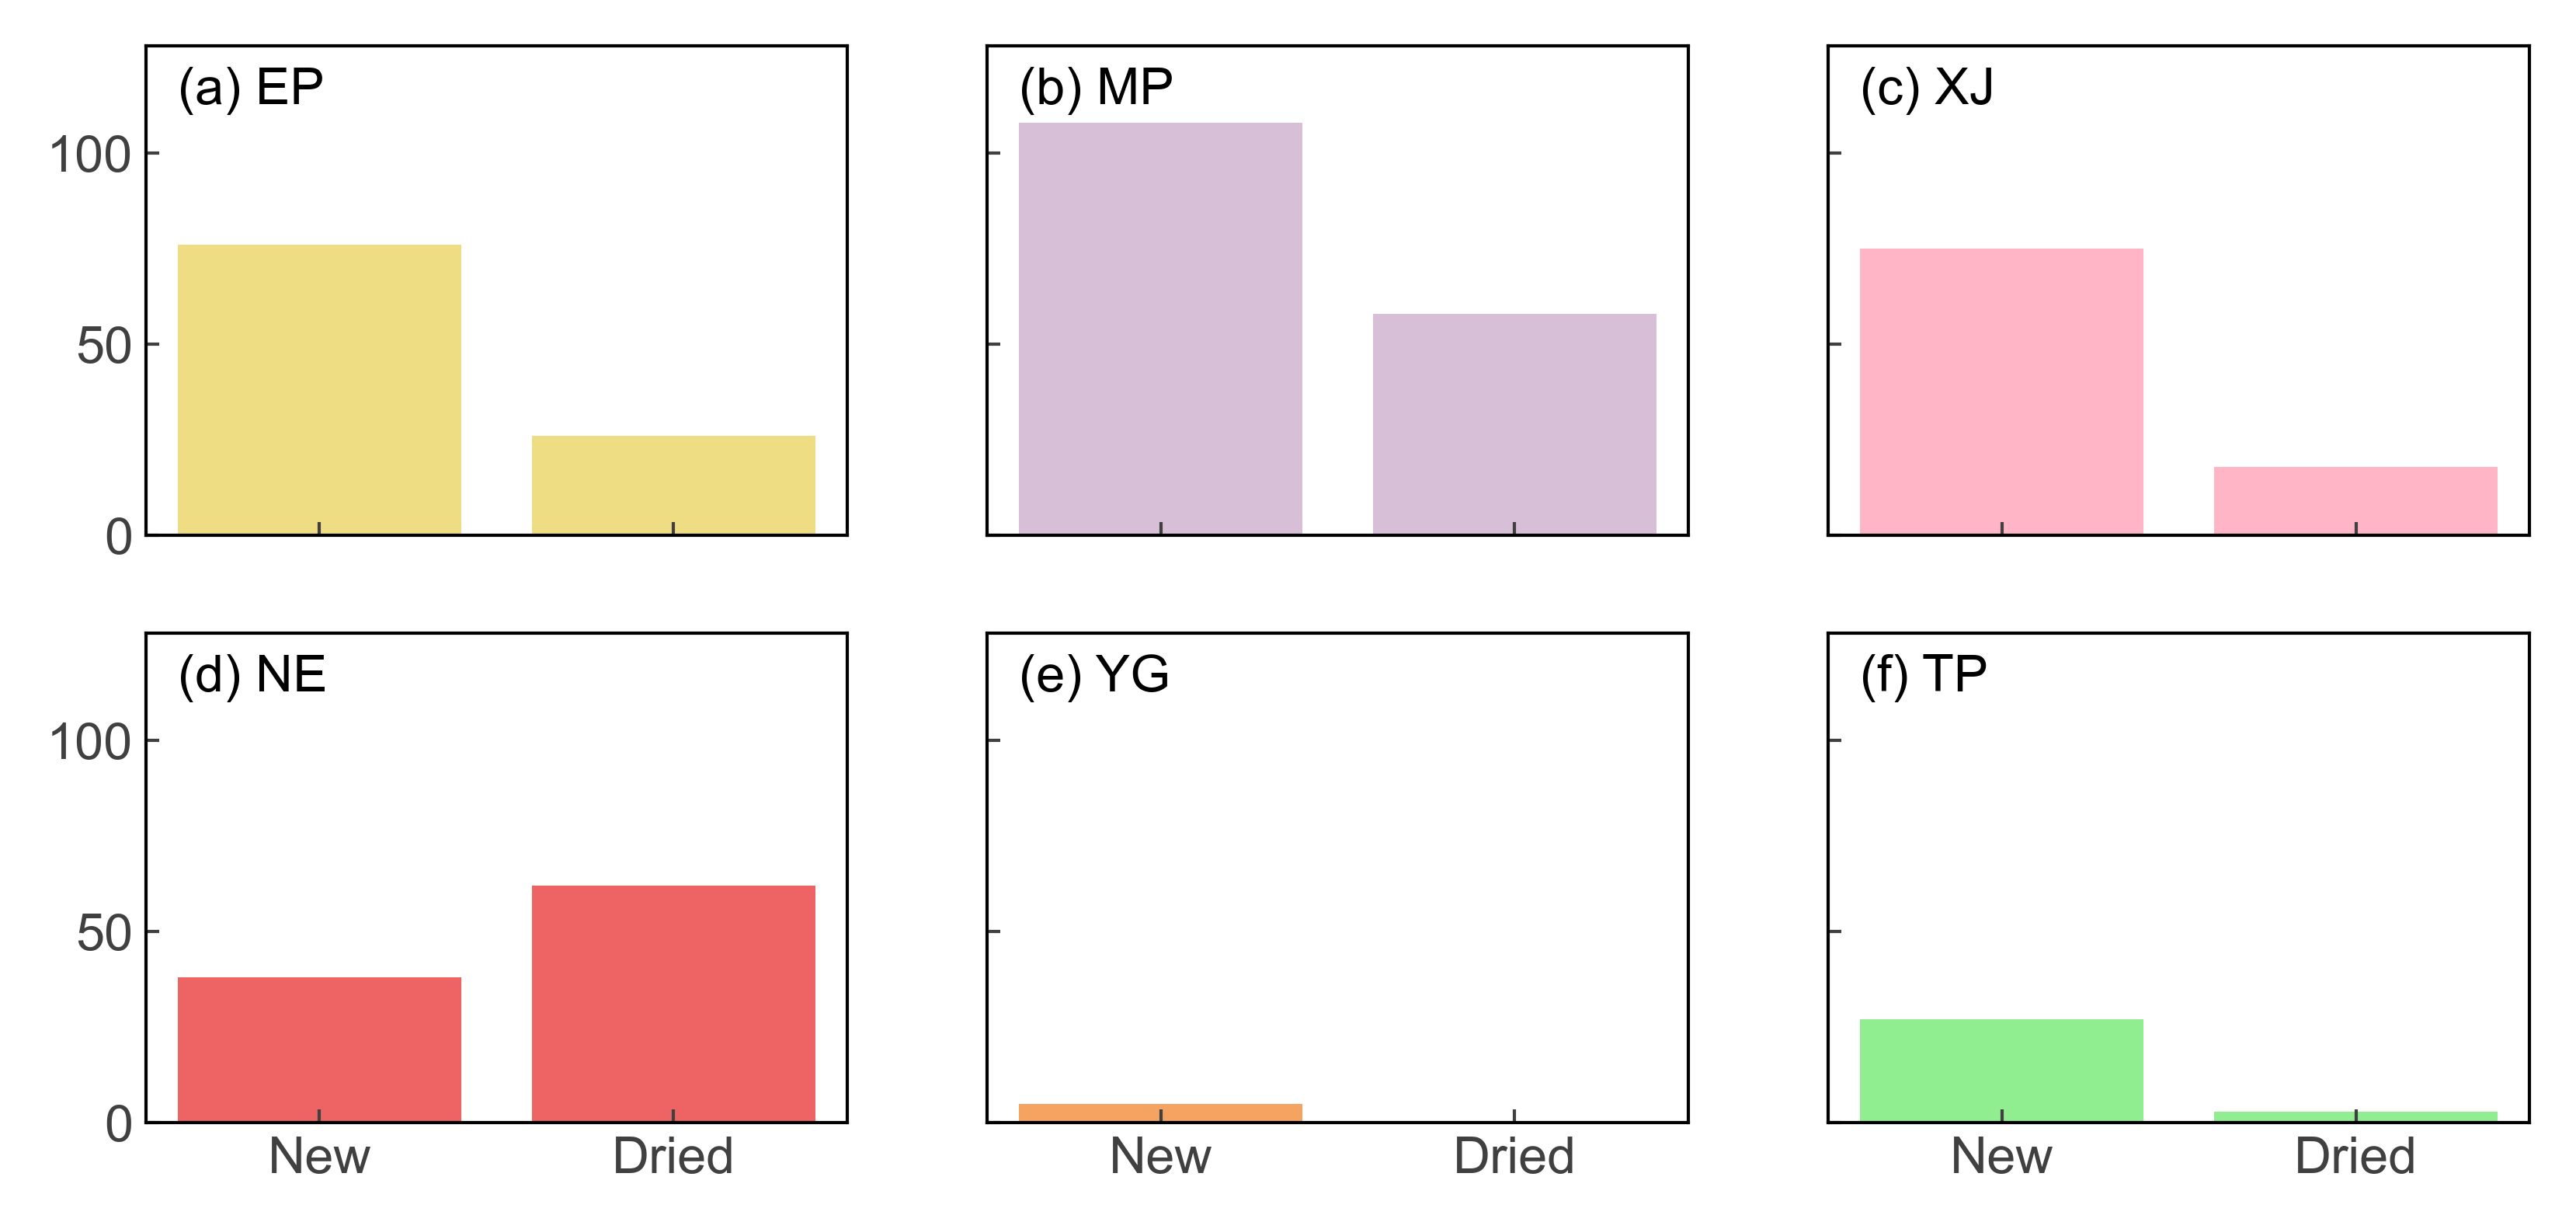

In [35]:
fig, axes = plt.subplots(2,3, figsize=(6.6,3), sharex=True, sharey=True, dpi=600)
for i, ax in enumerate(axes.ravel()):
    region_lake_list=lake_list[lake_list['Region']==regions[i]]
    new_lake_num=len(region_lake_list[(region_lake_list['2000']==0)&(region_lake_list['2019']!=0)])
    dry_lake_num=len(region_lake_list[(region_lake_list['2000']!=0)&(region_lake_list['2019']==0)])
    
    ax.text(-0.4,113,'({}) {}'.format(chr(97+i),regions[i]))
    ax.bar(['New','Dried'],[new_lake_num,dry_lake_num],color=colors[i])
    ax.set_ylim([0,128])
    ax.spines['bottom'].set_linewidth(lw[1])
    ax.spines['top'].set_linewidth(lw[1])#.set_visible(False)
    ax.spines['left'].set_linewidth(lw[1])
    ax.spines['right'].set_linewidth(lw[1])#.set_visible(False)
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)

## 4. calculate the RWA
the RWA of medium and large lakes(>10$km^2$) was calculated for each lake region during 10 periods using the following equation:
$$ RWA(\%)=1/n\sum_{i=1}^n(A_i/A_i^s)×100$$
where n,$A_i$ and $A_i^s$ represent the number of the medium and large lakes (>10 $km^2$), the area of the ith lake and the area of the $i$th lake in the base period, respectively.

In [8]:
columns=['Lake_id','Region']+['P{}'.format(i) for i in range(1,11)]
lake_change_list=pd.DataFrame(columns=columns)
index=0
for l_id in tqdm(lake.index):
    for r_id in six_region.index:
        region=six_region.loc[r_id]['geometry']
        region_name=six_region.loc[r_id]['name']
        if region.contains(lake.loc[l_id]['geometry'].centroid):
            lake_id=lake.loc[l_id]['Lake_id']
            lake_time_series=copy.copy(China_Lakes_time_series[China_Lakes_time_series['GLAKES_ID']==lake_id])
            
            if (lake_time_series.iloc[0]['Year']<2002) & (lake_time_series.iloc[0]['Area_dr']>10):
                As=lake_time_series.iloc[0]['Area_dr']
                lake_time_series['Ai']=lake_time_series['Area_dr']/As*100
                lake_change=[lake_id,region_name]
                #five period
                for i in np.arange(2000,2020,1):
                    period=lake_time_series[lake_time_series['Year'].map(lambda x: x>=i and x<i+2)]['Ai'].mean()
                    lake_change.append(period)
                lake_change_list.loc[index]=lake_change
                index=index+1               
            break
lake_change_list.to_csv('lake_change_list.csv')
lake_change_list

  0%|          | 0/6066 [00:00<?, ?it/s]

In [575]:
lake_change_list=pd.read_csv('lake_change_list.csv')
lake_change_list

,Unnamed: 0,Lake_id,Region,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
0,0,46,TP,99.698534,99.301727,99.319921,99.898564,100.219669,100.819181,101.946947,102.098246,102.855247,104.106594
1,1,66,EP,92.717444,100.422466,86.516000,76.435522,73.192708,75.796868,90.186237,82.488876,93.124290,76.665485
2,2,83,EP,100.593019,101.295794,101.372479,101.179832,101.131355,99.655282,99.248367,100.104805,99.884008,99.363861
3,3,85,TP,101.191909,106.030152,108.834540,111.759978,113.492079,115.021635,116.294919,116.616468,116.291713,116.772871
4,4,99,MP,98.855470,98.520485,95.689815,92.792209,88.747624,85.632408,87.211276,97.536851,98.948380,98.210494
...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,639,16229,EP,100.558497,101.166415,100.757757,101.097685,99.429978,98.065715,98.254306,98.394377,96.570301,96.157039
640,640,16265,EP,99.512754,100.108609,99.680402,98.966466,99.094455,98.573739,97.550841,97.968983,97.543243,96.879570
641,641,16738,XJ,100.412315,100.566005,101.069948,101.305551,101.991419,101.796244,103.169413,103.237161,104.266802,104.259556
642,642,16878,TP,101.029338,101.938287,101.911429,101.926074,101.861599,102.055096,101.943352,102.037042,102.058677,102.055096


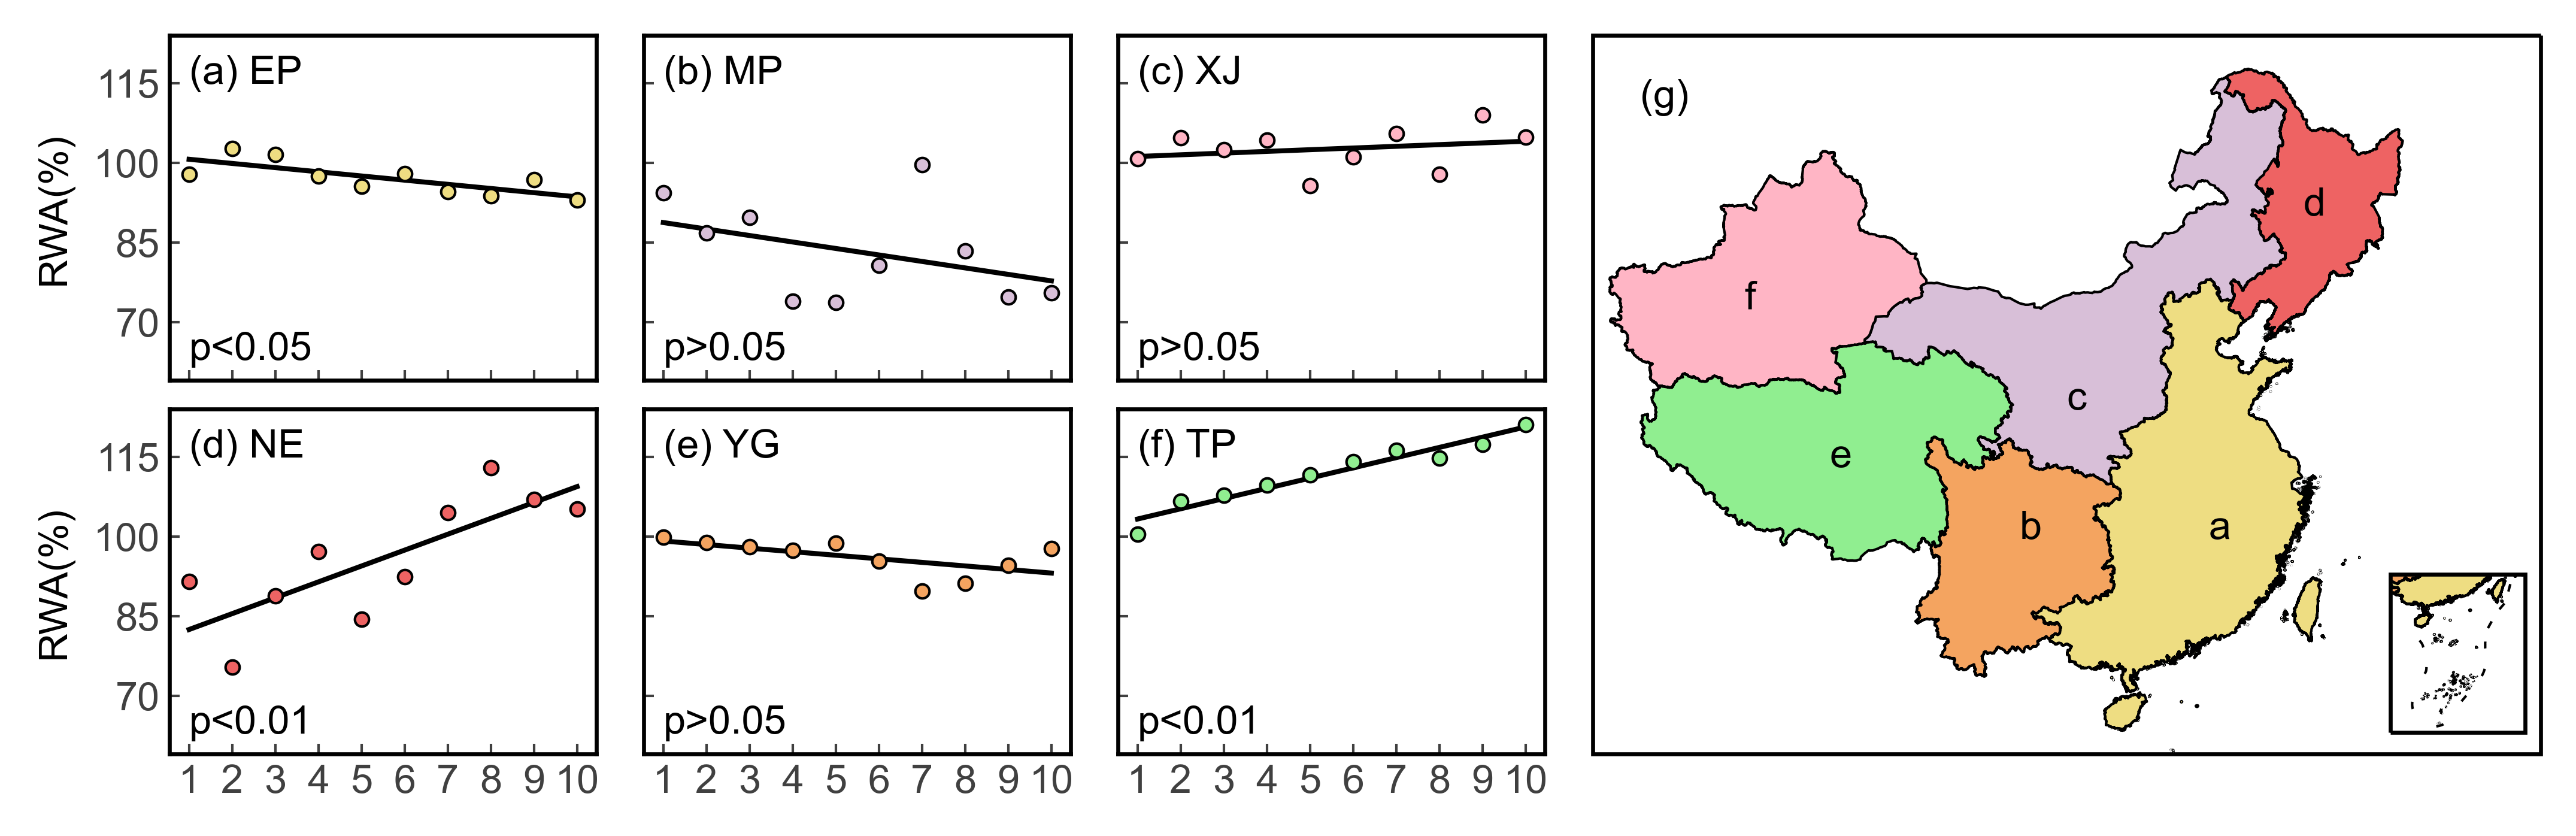

In [574]:
fig = plt.figure(figsize=(6.6,2), dpi=600)
ax1=fig.add_axes([0, 0.52, 0.18, 0.48])
ax2=fig.add_axes([0.2, 0.52, 0.18, 0.48])
ax3=fig.add_axes([0.4, 0.52, 0.18, 0.48])
ax4=fig.add_axes([0, 0, 0.18, 0.48])
ax5=fig.add_axes([0.2, 0, 0.18, 0.48])
ax6=fig.add_axes([0.4, 0, 0.18, 0.48])
ax7=fig.add_axes([0.6, 0, 0.4, 1],projection=proj)
ax7.set_extent([80, 133, 17, 54], crs=ccrs.PlateCarree())
ax8=fig.add_axes([0.87, 0.03, 0.19, 0.22],projection=ccrs.PlateCarree())

axes=[ax1,ax2,ax3,ax4,ax5,ax6]

for i, ax in enumerate(axes):
    
    change=lake_change_list[lake_change_list['Region']==regions[i]]
    mean=change.iloc[:,2:12].mean()
#     std=change.iloc[:,2:12].std()
    ax.scatter(xticks,mean,s=8,c=colors[i],linewidths=lw[1],edgecolors='k',zorder=1)
    
    # 拟合线性模型
    X=np.array(xticks).reshape((-1, 1))
    model = LinearRegression()
    model.fit(X, mean)
    #进行预测
    mean_bar = model.predict(X)
    ax.plot(xticks,mean_bar,'k',linewidth=lw[3],zorder=0)
    # 为特征矩阵添加常数列
    X_with_intercept = sm.add_constant(X)
    # 创建最小二乘模型
    model_ols = sm.OLS(mean, X_with_intercept).fit()
    
    # p检验
    p=model_ols.pvalues.x1
    text='p>0.05'
    if p<0.01:
        text='p<0.01'
    elif p<0.05:
        text='p<0.05'
    ax.text(1,63,text)
    
    ax.spines['bottom'].set_linewidth(lw[2])
    ax.spines['top'].set_linewidth(lw[2])
    ax.spines['left'].set_linewidth(lw[2])
    ax.spines['right'].set_linewidth(lw[2])
    
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)

    if(i%3==0):
        ax.set_ylabel('RWA(%)')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        
    if i<3 :
        ax.xaxis.set_major_formatter(plt.NullFormatter())
#     ax.set_title(region_name)
    ax.text(1,115,'({}) {}'.format(chr(97+i),region[i]))
    ax.set_ylim([59,124])
    ax.set_yticks([70,85,100,115])
    ax.set_xticks(xticks)
    ax7.add_geometries(six_region[six_region['name']==regions[i]]['geometry'],crs=ccrs.PlateCarree(),facecolor=colors[i],edgecolor='black',linewidth=lw[1])
    ax8.add_geometries(six_region[six_region['name']==regions[i]]['geometry'],crs=ccrs.PlateCarree(),facecolor=colors[i],edgecolor='black',linewidth=lw[1])
    
ax7.add_geometries(southern_sea_island['geometry'],facecolor='white',edgecolor='black',linewidth=lw[1],crs=ccrs.PlateCarree())
ax7.spines['geo'].set_linewidth(lw[2])
draw_label(ax7,0.05,0.9,'(g)')
draw_label(ax7,0.65,0.3,'a')
draw_label(ax7,0.45,0.3,'b')
draw_label(ax7,0.5,0.48,'c')
draw_label(ax7,0.75,0.75,'d')
draw_label(ax7,0.25,0.4,'e')
draw_label(ax7,0.16,0.62,'f')

ax8.spines['geo'].set_linewidth(lw[2])
ax8.set_extent([105, 125, 2.5, 26],crs=ccrs.PlateCarree())
add_northern_sea(ax8)

## 5.气候变化因素分析

In [20]:
fig, axes = plt.subplots(2,3, figsize=(6.6,3), sharex=True, sharey=True, dpi=600)
xtic=range(2000,2020)
for i, ax in enumerate(axes.ravel()):
    region=six_region[six_region['name']==regions[i]]#['geometry']
#     region
    precp=pre.pre#.interp(lon=np.arange(69.75,140.26,0.25),lat=np.arange(14.75,55.26,0.25))
    precp.rio.write_crs("epsg:4326", inplace=True)
    precp.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    cliped = precp.rio.clip(region.geometry.apply(mapping),region.crs,drop=False)
#     region_pre.append(cliped)
    meanP=cliped.mean(dim=['lat', 'lon'])
    maxP=cliped.max(dim=['lat', 'lon'])
    minP=cliped.min(dim=['lat', 'lon'])
    print(minP.values)
    print(maxP.values)
    ax.fill_between(xtick, minP.values, maxP.values,facecolor=colors[i], alpha=0.50)
    ax.plot(xtick,meanP,colors[i],linewidth=lw[1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.set_ylabel('$A/A^s (\%)$')
    ax.set_xlabel('Year')
    ax.set_xticks(np.arange(2000,2021,5))
    ax.set_xlabel('Year')
    ax.text( )

AttributeError: 'DataArray' object has no attribute 'write_crs'

In [ ]:
region=six_region[six_region['name']=='YG']#['geometry']
#     region
precp=pre.pre#.interp(lon=np.arange(69.75,140.26,0.25),lat=np.arange(14.75,55.26,0.25))
precp.rio.write_crs("epsg:4326", inplace=True)
precp.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
cliped = precp.rio.clip(region.geometry.apply(mapping),region.crs,drop=False)
cliped.isel(time=1).plot(robust=True, figsize=(8, 6))